<img src="mrc.png" alt="Description de l'image" width="1400" height="100">

## <span style="color: red;">Chilhood Tuberculosis Study</span>

### <span style="color: red;">Data Cleaning</span>

####  <span style="color: red;"> Data cleaning steps performed</span>

- Standardized column names using `clean_names()`.
- Renamed columns for better readability and clarity.
- Dropped irrelevant or unnecessary columns.
- Cleaned textual values:
  - Standardized to lowercase and removed extra spaces/special characters.
  - Replaced missing values (`n/a`, `?`, `unknown`, etc.) with `NaN`.
  - Parsed valid date strings to the `YYYY-MM-DD` format.
- Created a new `country` variable extracted from patient IDs.
- Created an `age` variable based on date of birth and participation date.
- Removed duplicate rows based on patient ID.
- Inspected missing values (count and proportion per variable).
- Imputed missing values in the dataset
- Saved the cleaned dataset to a new CSV file 


#### <span style="color: red;"> Load Packages</span>

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns  
import missingno as msn   
import janitor
import re     
from dateutil import parser
# Install local package using "pip install -e . --config-setting editable_mode=compat"
import src  
from src.clean import load_data_and_dict                         

#### <span style="color: red;">Load the dataset</span>

In [2]:
# Load the west africa data
dfwa = pd.read_excel('/mnt/c/Users/sanam/Desktop/HDWRA/alerrt_fissa/data_by_region/Database fissa - West Africa Region.xlsx')

# Shape of the data
print(f"Shape of the data: {dfwa.shape}")

Shape of the data: (21493, 1784)


**The west africa dataset contains 21493 rows, representing the number of observations, and  1784  columns, representing the number of variables.**

####  <span style="color: red;"> Fisrt few rows of the dataset</span>

In [3]:
# Display first 5 rows of the dataset
display(dfwa.head()) 

,age_group,Region,Site_reel,id_participant,redcap_repeat_instrument,redcap_repeat_instance,fievre,faisabilite_contact,age˂2mois,hospt_14derniers_jours,...,prov_trt_other,pres_trt_n,prov_trt_n,trt_dup,trt_forms,covid,parasitic,bacterial,hosp_inc,hosp_any
0,NaN,Afrique_ouest,CI,CIAA0001,Eligibility,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Afrique_ouest,CI,CIAA0001,examen_labo,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,Afrique_ouest,CI,CIAA0001,formulaire_traitement,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,Afrique_ouest,CI,CIAA0002,Eligibility,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,Afrique_ouest,CI,CIAA0002,formulaire_traitement,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



####  <span style="color: red;"> Clean empty columns and rows</span>


In [4]:
# Drop empty columns
dfwa = dfwa.dropna(axis=1, how='all')

# Drop empty rows 
dfwa = dfwa.dropna(axis=0, how='all')

# Print the new shape of the dataset
print(f"New shape of the dataset: {dfwa.shape}")


New shape of the dataset: (21493, 1425)


**359 empty columns have been dropped. The West Africa dataset now contains 21,493 rows and 1,425 columns.**

In [5]:
from collections import Counter

# Create a list of unique column names by appending suffixes to duplicates
new_columns = []
seen = {}

for col in dfwa.columns:
    if col not in seen:
        seen[col] = 0
        new_columns.append(col)
    else:
        seen[col] += 1
        new_columns.append(f"{col}.{seen[col]}")

# Assign the new column names to the DataFrame
dfwa.columns = new_columns


# Display duplicate column names
counts = Counter(dfwa.columns)
duplicates = [col for col, count in counts.items() if count > 1]
print(duplicates)

[]


####  <span style="color: red;">Age calculation based on multiple columns</span>

In [6]:
# Convert date columns
dfwa['date_inc'] = pd.to_datetime(dfwa['date_inc'], errors='coerce')
dfwa['date_naissance'] = pd.to_datetime(dfwa['date_naissance'], errors='coerce')

# Calculate age from date of birth
dfwa['age_from_dob'] = ((dfwa['date_inc'] - dfwa['date_naissance']).dt.days) / 365.25

# Ensure numeric conversion for all relevant age columns
for col in ['age', 'age_mois', 'age_annee', 'age_enfant_mois', 'age_année']:
    dfwa[col] = pd.to_numeric(dfwa[col], errors='coerce')

# Compute age from months (convert to years)
dfwa['age_from_months'] = dfwa[['age_mois', 'age_enfant_mois']].max(axis=1) / 12

# Compute age from year fields (take the maximum)
dfwa['age_from_years'] = dfwa[['age_annee', 'age_année']].max(axis=1)

# Combine age information into a single column 'age_final'
dfwa['age_final'] = dfwa['age_from_dob'].combine_first(dfwa['age'])
dfwa['age_final'] = dfwa['age_final'].combine_first(dfwa['age_from_years'])
dfwa['age_final'] = dfwa['age_final'].combine_first(dfwa['age_from_months'])

# Round to 2 decimals
dfwa['age_final'] = dfwa['age_final'].round(0)

# Drop intermediate columns used for computing age
columns_to_drop = ['date_inc', 'date_naissance', 'age', 'age_mois', 'age_en'
                   'age_annee', 'age_enfant_mois', 'age_année', 'age_connu',
                   'age_from_dob', 'age_from_months', 'age_from_years', 'date_naissance_connue'
]

dfwa.drop(columns=[col for col in columns_to_drop if col in dfwa.columns], inplace=True)

# Rename 'age_final' to 'age'
dfwa.rename(columns={'age_final': 'age'}, inplace=True)

####  <spanA style="color: red;"> Data cleaning pipeline </span>

In [7]:
# Cleaning function
def clean_column(val):
    if pd.isna(val):
        return val
    val = str(val).strip()
    
    # Detect and normalize valid date strings
    try:
        parsed_date = parser.parse(val, fuzzy=False)
        return parsed_date.strftime('%d-%m-%Y')
    except (ValueError, TypeError):
        pass  

    val = val.lower()
    
    # Replace invalid or missing values
    if re.match(r"^\s*$|^_+$|^(n/a|na|null|none|unknown|\?)$", val, re.IGNORECASE):
        return pd.NA

    # Normalize text values
    val = re.sub(r"\s+", "_", val)         
    #val = re.sub(r"[^a-zA-Z0-9_]", "", val)  
    return val

# Cleaning pipeline
dfwa = (
    dfwa
    .clean_names()
    .apply(lambda col: col.map(clean_column) if col.dtype == "object" else col)
    #.drop_duplicates(subset='q1_pre_tb')
)

# Display the cleaned DataFrame
display(dfwa.head())

,age_group,region,site_reel,id_participant,redcap_repeat_instrument,redcap_repeat_instance,fievre,faisabilite_contact,age˂2mois,hospt_14derniers_jours,...,aut_rais_oppos_fam,rais_oppos_pat_1,rais_oppos_pat_2,rais_oppos_pat_3,autr_rais_oppos_pat,aut_rais_obst_adapt,rempli_2,dat_rempli_7,conclusion_form_complete,age
0,NaN,afrique_ouest,ci,ciaa0001,eligibility,NaN,1.0,1.0,0.0,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,ata,10-03-2020,2.0,38.0
1,NaN,afrique_ouest,ci,ciaa0001,examen_labo,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,afrique_ouest,ci,ciaa0001,formulaire_traitement,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,afrique_ouest,ci,ciaa0002,eligibility,NaN,1.0,1.0,0.0,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,ata,10-03-2020,2.0,39.0
4,0.0,afrique_ouest,ci,ciaa0002,formulaire_traitement,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
dfwa.columns.tolist()

['age_group',
 'region',
 'site_reel',
 'id_participant',
 'redcap_repeat_instrument',
 'redcap_repeat_instance',
 'fievre',
 'faisabilite_contact',
 'age˂2mois',
 'hospt_14derniers_jours',
 'inclussion_patient_fissa',
 'inclussion_patient_fissa_1',
 'signature_formulaire_consentement',
 'verification_criteres_egibilite_consentement_',
 'confirme_par',
 'date_confirmation',
 'eligibility_complete',
 'heure_admission',
 'date_naissance_connue',
 'age_connu',
 'age_en',
 'sexe',
 'dist_dom_ets',
 'moy_deplac_participant',
 'moy_deplacement',
 'niv_educ_connu',
 'niv_educ',
 'partir_voyage',
 'nom_dest',
 'part_soins_ant',
 'part_soins_ant_lieu_1',
 'part_soins_ant_lieu_2',
 'part_soins_ant_lieu_3',
 'part_soins_ant_lieu_4',
 'part_soins_ant_lieu_5',
 'part_soins_ant_autre',
 'part_origin',
 'part_origin_autre',
 'part_ttt_ant',
 'temps_ecoule_depuis_ttt_ant_connu',
 'temps_ttt_ant',
 'med_prescrit_1',
 'med_prescrit_2',
 'med_prescrit_3',
 'med_prescrit_4',
 'med_prescrit_5',
 'med_presc

#### <span style="color: red;">Missing data overview</span>

In [63]:
# Inspect Missing Values
missing_values = dfwa.isnull().sum()
missing_proportions = missing_values / len(dfwa )
missing_df = pd.concat([missing_values, missing_proportions], axis=1)

missing_df.columns = ['Number of Missing Values', 'Proportion of Missing Values']
missing_df = missing_df.sort_values('Proportion of Missing Values', ascending=False)

pd.reset_option('display.max_rows', None)
display(missing_df)

,Number of Missing Values,Proportion of Missing Values
no_procal_rais,21492,0.999953
autre3_antc_tps,21492,0.999953
autre3_atcd_ttt,21492,0.999953
res_autr_6,21492,0.999953
vacc_autr_3_2,21492,0.999953
...,...,...
age_group,252,0.011725
region,0,0.000000
redcap_repeat_instrument,0,0.000000
id_participant,0,0.000000



#### <span style="color: red;">Visualize missingness statistics</span>

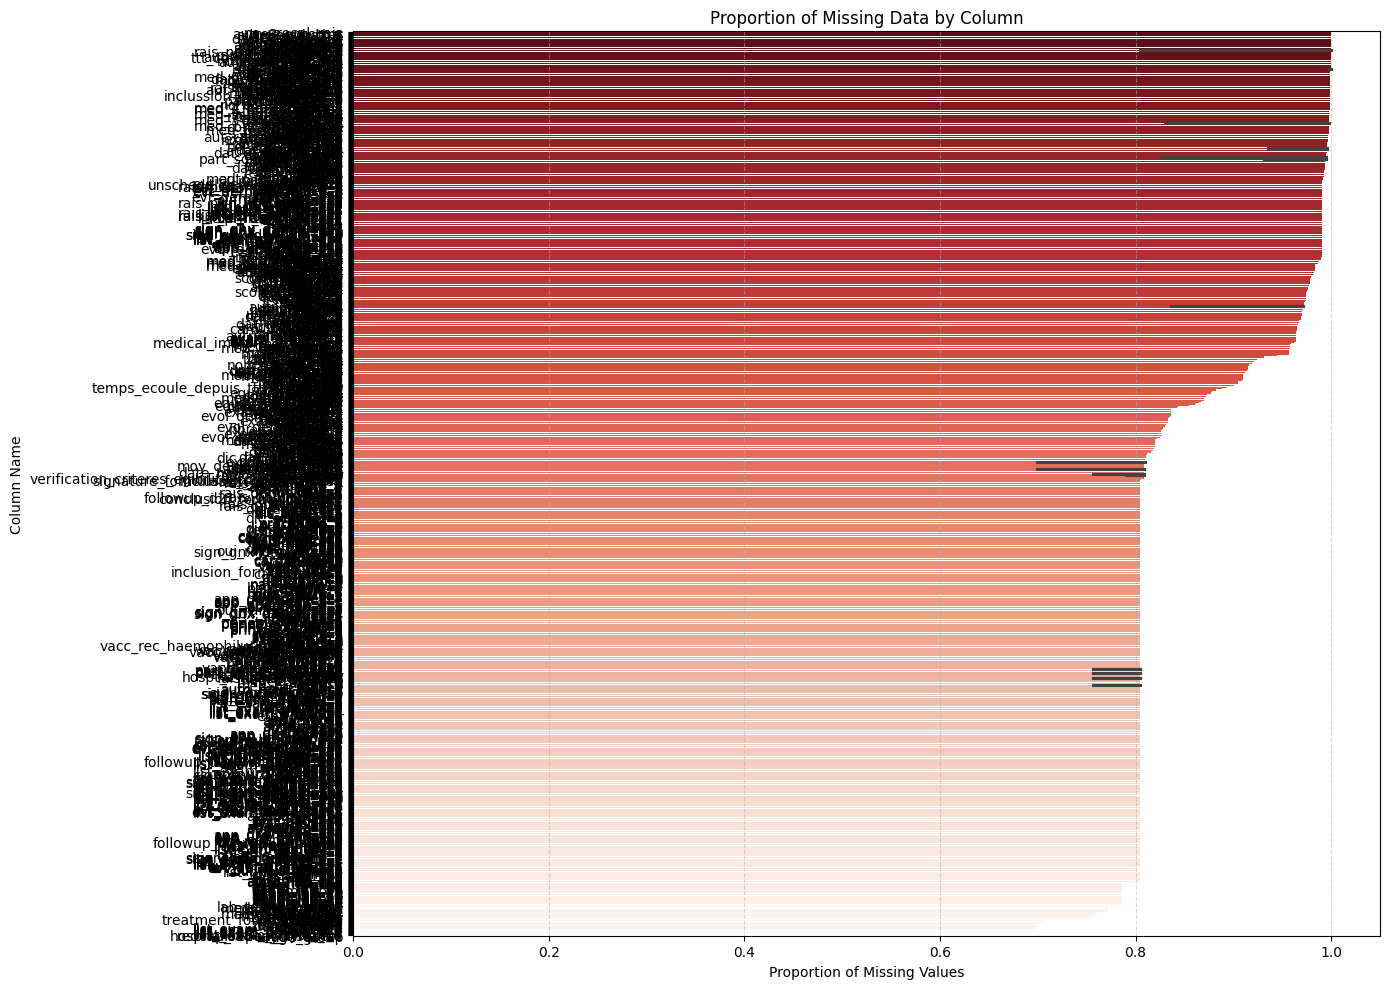

In [64]:
# Calculate missing values and proportions
missing_values = dfwa.isnull().sum()
missing_proportions = missing_values / len(dfwa)

# Combine into a single DataFrame
missing_df = pd.concat([missing_values, missing_proportions], axis=1)
missing_df.columns = ['Missing Count', 'Missing Proportion']
missing_df = missing_df.sort_values('Missing Proportion', ascending=False)

# Filter to only show columns with missing values
missing_df = missing_df[missing_df['Missing Count'] > 0]

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(
    data=missing_df.reset_index(),
    y='index',
    x='Missing Proportion',
    hue='index',             # Set hue to avoid FutureWarning
    palette='Reds_r',
    dodge=False,
    legend=False             # Hide legend (since hue is redundant here)
)
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Column Name')
plt.title('Proportion of Missing Data by Column')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

####  <span style="color: red;"> Save the cleaned dataset to a new CSV file</span>

In [ ]:
# Save the cleaned dataset
#dfwa.to_csv('cleaned_tb_dataset.csv', index=False)